# 💧 VQE-Based Bond Angle Optimization of Water (H₂O)

This notebook implements the **Variational Quantum Eigensolver (VQE)** to determine the **optimal bond angle of the water molecule (H₂O)** by minimizing its ground state energy across a range of geometries. The simulation is executed on a **noiseless quantum device** using PennyLane’s quantum chemistry module.

### Key Features:
- **Geometry Generator**: Constructs H₂O molecular geometries parametrized by bond angle (in degrees) with fixed bond length.
- **VQE Energy Evaluation**:
  - Applies a **UCCSD-style ansatz** with both single and double excitations.
  - Optimizes the ansatz parameters for each bond angle using the **Adam optimizer**.
- **Angle Sweep**: Evaluates the ground state energy at discrete H–O–H angles (from 100° to 109°).
- **Result Visualization**:
  - Plots energy vs. bond angle to identify the minimum.
  - Outputs the **optimal angle** and its corresponding **minimum energy**.

### Purpose:
To estimate the **equilibrium bond angle** of water using a quantum variational approach, enabling quantum simulation-driven geometry optimization — a key step in **ab initio quantum chemistry** using near-term quantum devices.

In [ ]:
import pennylane as qml                  # Quantum circuit builder and device management
from pennylane import numpy as np        # Not regular NumPy, but similar and supports automatic differentiation
from pennylane import qchem              # Quantum chemistry module used to define molecule Hamiltonians
from pennylane.qchem import excitations  # Single and double excitations used in the UCCSD (Unitary Coupled Cluster Singles and Doubles) ansatz
import matplotlib.pyplot as plt
import os
from vqe_utils import excitation_ansatz, get_optimizer, set_seed  # helpers

set_seed(0)                              # Reproducible runs
IMG_DIR = "images"                       # Single image directory used repo-wide
os.makedirs(IMG_DIR, exist_ok=True)

In [ ]:
def water_geometry(angle_deg, bond_length=0.9584):
    # Generate coordinates for water with given angle in degrees (bond length in Å)
    angle_rad = np.deg2rad(angle_deg)  # Convert to radians
    x = bond_length * np.sin(angle_rad / 2)
    z = bond_length * np.cos(angle_rad / 2)
    coordinates = np.array([
        [0.0, 0.0, 0.0],  # Oxygen
        [x, 0.0, z],      # Hydrogen 1
        [-x, 0.0, z]      # Hydrogen 2
    ])
    return coordinates

In [3]:
def run_vqe(angle_deg, max_iterations=15, stepsize=0.2):
    coordinates = water_geometry(angle_deg)
    symbols = ["O", "H", "H"]
    hamiltonian, qubits = qchem.molecular_hamiltonian(symbols, coordinates)
    
    electrons = 10
    hf = qchem.hf_state(electrons, qubits)
    singles, doubles = excitations(electrons, qubits)

    dev = qml.device("default.qubit", wires=qubits)

    @qml.qnode(dev)
    def cost_fn(params):
        excitation_ansatz(
            params,
            wires=range(qubits),
            hf_state=hf,
            excitations=(singles, doubles),
            excitation_type="both"
        )
        return qml.expval(hamiltonian)

    # Initialize combined parameter vector
    params = np.zeros(len(singles) + len(doubles), requires_grad=True)

    opt = get_optimizer("Adam", stepsize=stepsize)

    for _ in range(max_iterations):
        params, _ = opt.step_and_cost(cost_fn, params)

    final_energy = cost_fn(params)
    return final_energy

Running VQE for angle 100.0°
Running VQE for angle 102.2°
Running VQE for angle 104.5°
Running VQE for angle 106.8°
Running VQE for angle 109.0°


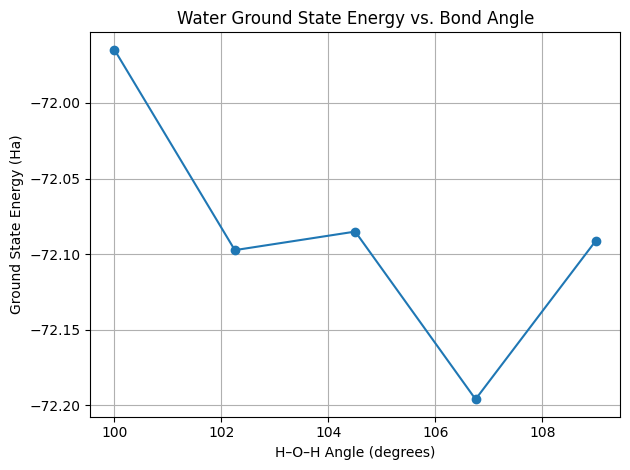

Minimum energy: -72.195913 Ha
Optimal angle: 106.75°


In [ ]:
# Define the angle range and initialize the energy
angles = np.linspace(100, 109, 5)  # Bond angles (in degrees) to test
energies = []

for angle in angles:
    # Iterates over each bond angle
    print(f"Running VQE for angle {angle:.1f}°")

    # Find the optimized ground state energy for that geometry
    energy = run_vqe(angle)
    energies.append(energy)

# Optimized energy plots
plt.plot(angles, energies, marker='o')
plt.xlabel('H–O–H Angle (°)')
plt.ylabel('Ground State Energy (Ha)')
plt.title('H₂O VQE: Energy vs. Bond Angle (Noiseless, UCCSD)')
plt.grid(True)
plt.tight_layout()
plt.savefig(f'{IMG_DIR}/H2O_Bond_Angle_Scan.png', dpi=300)
plt.show()

# Print the optimum bond-angle and the corresponding energy
min_energy = min(energies)
opt_angle = angles[np.argmin(energies)]
print(f"Minimum energy: {min_energy:.6f} Ha")
print(f"Optimal angle: {opt_angle:.2f}°")